In [16]:
import matplotlib.pyplot as plt
import scienceplots
from brokenaxes import brokenaxes

import numpy as np

import qiskit
from qiskit import QuantumCircuit

from qiskit_aer.noise import NoiseModel
from qiskit.providers.models import BackendProperties

from qiskit_aer import AerSimulator

import pickle

In [2]:
from qiskit import qasm3

In [33]:
counts_vec_real_kyoto = np.load("data/counts_kyoto.npy")
counts_vec_real_osaka = np.load("data/counts_osaka.npy")

In [68]:
with open('data/random_circuits_inputs_kyoto.pickle', 'rb') as handle:
    inputs_kyoto = pickle.load(handle)

with open('data/random_circuits_inputs_osaka.pickle', 'rb') as handle:
    inputs_osaka = pickle.load(handle)

with open('data/properties_kyoto.pickle', 'rb') as handle:
    properties_kyoto = pickle.load(handle)

with open('data/properties_kyoto.pickle', 'rb') as handle:
    properties_osaka = pickle.load(handle)

with open('data/coupling_map_kyoto.pickle', 'rb') as handle:
    coupling_map_kyoto = pickle.load(handle)

with open('data/coupling_map_osaka.pickle', 'rb') as handle:
    coupling_map_osaka = pickle.load(handle)

In [ ]:

inputs_kyoto['circuits'] = [qasm3.loads(c) for c in inputs_kyoto['circuits']]
inputs_osaka['circuits'] = [qasm3.loads(c) for c in inputs_osaka['circuits']]

In [25]:
circuits_kyoto = inputs_kyoto['circuits'] 
circuits_osaka = inputs_osaka['circuits']

shots = inputs_kyoto['shots']

In [69]:
properties_kyoto = BackendProperties.from_dict(properties_kyoto)
properties_osaka = BackendProperties.from_dict(properties_osaka)

In [70]:
noise_model_kyoto = NoiseModel.from_backend_properties(properties_kyoto)
noise_model_osaka = NoiseModel.from_backend_properties(properties_osaka)

In [71]:
qubits_kyoto = [43, 44, 45, 46]
qubits_osaka = [25, 26, 27, 28]


In [72]:
print("ibm_kyoto")
for q in qubits_kyoto:
    print(
        f"{q} {properties_kyoto.t1(q)*1e6} {properties_kyoto.t2(q)*1e6} {properties_kyoto.readout_error(q)} {properties_kyoto.qubit_property(q)['prob_meas1_prep0'][0]}"
    )

print("ibm_osaka")
for q in qubits_osaka:
    print(
        f"{q} {properties_osaka.t1(q)*1e6} {properties_osaka.t2(q)*1e6} {properties_osaka.readout_error(q)} {properties_osaka.qubit_property(q)['prob_meas1_prep0'][0]}"
    )

ibm_kyoto
43 38.62465065094961 320.94331825663966 0.017099999999999893 0.015599999999999947
44 375.1139924218498 201.81312150935295 0.007900000000000018 0.0066
45 292.5096961792252 376.82636831758697 0.006900000000000017 0.007
46 366.12917805914225 322.8324687697393 0.008099999999999996 0.009199999999999986
ibm_osaka
25 225.0584463838339 221.38198507584 0.049900000000000055 0.0462
26 272.1743173943456 278.5778874932316 0.005800000000000027 0.0054
27 227.76620733464685 94.28378700631171 0.006099999999999994 0.0052
28 173.14502688778018 27.88978975935019 0.03600000000000003 0.0486


In [73]:
# backend_sim_kyoto = AerSimulator.from_backend(backend_real_kyoto)
backend_sim_kyoto = AerSimulator(noise_model = noise_model_kyoto,
                                coupling_map = coupling_map_kyoto,
                                basis_gates=noise_model_kyoto.basis_gates)
backend_sim_kyoto.set_options(device='GPU')

# backend_sim_osaka = AerSimulator.from_backend(backend_real_osaka)
backend_sim_osaka = AerSimulator(noise_model = noise_model_osaka,
                                coupling_map = coupling_map_osaka,
                                basis_gates=noise_model_osaka.basis_gates)
backend_sim_osaka.set_options(device='GPU')



# Long run time if using two AerSimlators with GPU
backend_sim_ideal = AerSimulator()
# backend_sim_ideal.set_options(device='GPU')

In [74]:
job_sim_kyoto = backend_sim_kyoto.run(circuits_kyoto, shots=shots)
job_sim_osaka = backend_sim_osaka.run(circuits_osaka, shots=shots)
job_sim_ideal = backend_sim_ideal.run(circuits_osaka, shots=shots)

In [75]:
counts_sim_kyoto = job_sim_kyoto.result().get_counts()

In [76]:
counts_sim_osaka = job_sim_osaka.result().get_counts()


In [77]:
counts_sim_ideal = job_sim_ideal.result().get_counts()


In [78]:
def counts_to_vec(counts):
    vals = dict(sorted(counts.int_outcomes().items())).values()
    return np.array(list(vals)) / shots

counts_vec_sim_kyoto = np.stack([counts_to_vec(c) for c in counts_sim_kyoto])
counts_vec_sim_osaka = np.stack([counts_to_vec(c) for c in counts_sim_osaka])
counts_vec_sim_ideal = np.stack([counts_to_vec(c) for c in counts_sim_ideal])

In [79]:
from scipy.stats import gamma
a = 16.76398344104434  # shape parameter (alpha)
scale = 0.007456461672107913  # scale parameter (theta)

# Create the gamma distribution
g = gamma(a, scale=scale)
xrange = np.linspace(0,0.35, 1000)

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
[3.5   2.625]


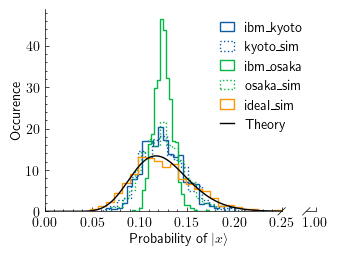

In [80]:
with plt.style.context('science', 'ieee`'):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    print(colors)

    bax = brokenaxes(xlims=((0, 0.25), (0.99, 1)))
    nbins = 25


    # plt.hist(counts_vec_all, bins=nbins, density=True, stacked=True, label=labels)

    bax.hist(counts_vec_real_kyoto.reshape(-1), density=True, bins=nbins, label='ibm_kyoto', histtype='step', color=colors[0])
    bax.hist(counts_vec_sim_kyoto.reshape(-1), density=True,  bins=nbins, label='kyoto_sim', histtype='step', ls='dotted', color=colors[0])
    bax.hist(counts_vec_real_osaka.reshape(-1), density=True, bins=nbins, label='ibm_osaka', histtype='step', color=colors[1])
    bax.hist(counts_vec_sim_osaka.reshape(-1), density=True,  bins=20,    label='osaka_sim', histtype='step', ls='dotted', alpha=1, color=colors[1])
    bax.hist(counts_vec_sim_ideal.reshape(-1), density=True,  bins=nbins, label='ideal_sim', histtype='step', ls='-', alpha=1, color=colors[2])
    bax.plot(xrange, g.pdf(xrange), label='Theory', color='black', alpha=1)
    
    bax.set_xlabel(r'Probability of $\left|x\right\rangle $')
    bax.set_ylabel(r'Occurence', labelpad=16)
    leg = bax.legend(handlelength=1)
    bax.tick_params()

fig = plt.gcf()
size = fig.get_size_inches()
print(size)


plt.show()

In [81]:
from scipy import stats

ecdf_real_kyoto = stats.ecdf(counts_vec_real_kyoto.reshape(-1))
ecdf_real_osaka = stats.ecdf(counts_vec_real_osaka.reshape(-1))
ecdf_sim_kyoto = stats.ecdf(counts_vec_sim_kyoto.reshape(-1))
ecdf_sim_osaka = stats.ecdf(counts_vec_sim_osaka.reshape(-1))
ecdf_sim_ideal = stats.ecdf(counts_vec_sim_ideal.reshape(-1))


print(stats.kstest(counts_vec_real_kyoto.reshape(-1), g.cdf))
print(stats.kstest(counts_vec_real_osaka.reshape(-1), g.cdf))
print(stats.kstest(counts_vec_sim_kyoto.reshape(-1), g.cdf))
print(stats.kstest(counts_vec_sim_osaka.reshape(-1), g.cdf))

KstestResult(statistic=0.10342369275491392, pvalue=6.647140436517514e-08, statistic_location=0.102294921875, statistic_sign=-1)
KstestResult(statistic=0.2755894148989497, pvalue=3.3938136927452474e-54, statistic_location=0.1099639892578125, statistic_sign=-1)
KstestResult(statistic=0.08110088442652884, pvalue=5.031070027822661e-05, statistic_location=0.09765625, statistic_sign=-1)
KstestResult(statistic=0.10935081931301016, pvalue=8.716943361760823e-09, statistic_location=0.10205078125, statistic_sign=-1)


[3.5   2.625]


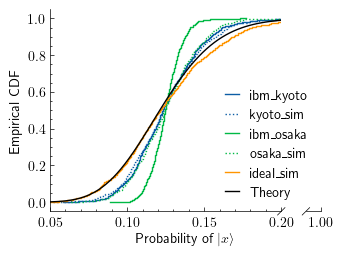

In [82]:
cdf_range = np.linspace(0, 0.25, 100)
cdf_ideal = gamma(a=26.483675759507783, loc=-0.029209393141463653, scale=0.005750784938985662).cdf(cdf_range)

with plt.style.context('science', 'ieee`'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # plt.figure(figsize=(fig_width, fig_height))

    bax = brokenaxes(xlims=((0.05, 0.2), (0.99, 1)))


    ecdf_real_kyoto.cdf.plot(label='ibm_kyoto', ls='-', ax=bax, color=colors[0])
    ecdf_sim_kyoto.cdf.plot(label='kyoto_sim',  ls='dotted', ax=bax, color=colors[0])
    ecdf_real_osaka.cdf.plot(label='ibm_osaka', ls='-', ax=bax, color=colors[1])
    ecdf_sim_osaka.cdf.plot(label='osaka_sim',  ls='dotted', ax=bax, color=colors[1])
    ecdf_sim_ideal.cdf.plot(label='ideal_sim',  ls='-', ax=bax, color=colors[2])
    bax.plot(cdf_range, cdf_ideal, label='Theory', c='black')

    bax.set_xlabel(r'Probability of $\left|x\right\rangle $')
    bax.set_ylabel(r'Empirical CDF', labelpad=20)
    bax.legend(loc=4, handlelength=1)

    bax.tick_params()

fig = plt.gcf()
size = fig.get_size_inches()
print(size)

plt.show()

[3.5   2.625]


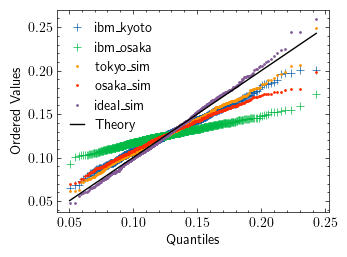

In [83]:
common_opts = dict(marker="+", linestyle='none', mew=0.5)
common_opts_sim = dict(marker=".", linestyle='none', mew=1)

with plt.style.context('science', 'ieee`'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # plt.figure(figsize=(fig_width, fig_height))

    res_real_kyoto = stats.probplot(counts_vec_real_kyoto.reshape(-1), dist=g, plot=None,)
    res_real_osaka = stats.probplot(counts_vec_real_osaka.reshape(-1), dist=g, plot=None,)
    res_sim_kyoto = stats.probplot(counts_vec_sim_kyoto.reshape(-1), dist=g, plot=None)
    res_sim_osaka = stats.probplot(counts_vec_sim_osaka.reshape(-1), dist=g, plot=None)
    res_sim_ideal = stats.probplot(counts_vec_sim_ideal.reshape(-1), dist=g, plot=None)

    plt.plot(res_real_kyoto[0][0], res_real_kyoto[0][1], label='ibm_kyoto', **common_opts,)
    plt.plot(res_real_osaka[0][0], res_real_osaka[0][1], label='ibm_osaka', **common_opts,)
    plt.plot(res_sim_kyoto[0][0], res_sim_kyoto[0][1], label='tokyo_sim', **common_opts_sim, ms=2,alpha=1)
    plt.plot(res_sim_osaka[0][0], res_sim_osaka[0][1], label='osaka_sim', **common_opts_sim, ms=2,alpha=1)
    plt.plot(res_sim_ideal[0][0], res_sim_ideal[0][1], label='ideal_sim', **common_opts_sim, ms=2,alpha=1)


    # Draw the theory line
    slope, intercept = 1, 0
    line_values = slope * res_real_kyoto[0][0] + intercept
    plt.plot(res_real_kyoto[0][0], line_values, label='Theory', color='black')

    # plt.axis('square')
    plt.xlabel('Quantiles')
    plt.ylabel('Ordered Values')
    plt.legend(handlelength=1, loc=2)

    plt.xticks()
    plt.yticks()

fig = plt.gcf()
size = fig.get_size_inches()
print(size)
plt.show()